<a href="https://colab.research.google.com/github/agbleze/image_background_remover/blob/main/image_background_remove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from metrics import dice_loss, dice_coef, iou
#from train import create_dir

""" Global parameters """
H = 512
W = 512

In [ ]:
np.random.seed(2023)
tf.random.set_seed(2023)
from google.colab.patches import cv2_imshow




In [ ]:
img_path = "/content/Remove-Photo-Background-using-TensorFlow/images/beyonceandjay-z-Mikecoppola-c59229db80174b3290431f66eea3d8ff.jpg"

img1 = cv2.imread(img_path)

cv2_imshow(img1)

In [ ]:
class ImageBackgroundChanger(object):
  DEFAULT_IMG_HEIGHT = 512
  DEFAULT_IMG_WIDTH = 512
  def __init__(self, image_path):
    self.image = cv2.imread(image_path, cv2.IMREAD_COLOR)

  def load_model(self, model_path):
    self.model_path = model_path
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef,
                            'dice_loss': dice_loss}
                           ):
        self.model = tf.keras.models.load_model(self.model_path)
    return self.model


  def image_preprocess(self):
    self.img_height, self.img_width, _ = self.image.shape
    image_resize = cv2.resize(self.image, (self.DEFAULT_IMG_WIDTH, self.DEFAULT_IMG_HEIGHT))
    image_rescale = image_resize/255.0
    img_type_converted = image_rescale.astype(np.float32)
    self.preprocessed_img = np.expand_dims(img_type_converted, axis=0)
    return self.preprocessed_img


  def segment_image(self, model = None, preprocessed_img = None,
                    #img_resize_height=None,
                    #img_resize_width=None
                    ):
    if model:
      self.model = model

    if preprocessed_img:
      self.preprocessed_img = preprocessed_img

    img_predicted = self.model.predict(self.preprocessed_img)[0]
    img_predicted_resize = cv2.resize(img_predicted,
                                      (self.img_width,
                                       self.img_height
                                       )
                                      )
    img_predicted_expand = np.expand_dims(img_predicted_resize, axis=-1)
    self.img_mask = img_predicted_expand > 0.5
    self.background_mask = np.abs(1-self.img_mask)


  def change_background_color(self, #image, img_mask, background_mask,
                              Blue_Green_Red_color: list = [0, 0, 255]
                              ):
    #if image:
    #  self.image = image

    img_with_mask = self.image * self.img_mask
    background_mask_concat = np.concatenate([self.background_mask,
                                             self.background_mask,
                                            self.background_mask
                                            ],
                                              axis=-1
                                            )
    background_mask_concat_with_color = (background_mask_concat *
                                         Blue_Green_Red_color
                                         )
    image_with_background_changed = img_with_mask + background_mask_concat_with_color
    return image_with_background_changed












In [ ]:
img_bgrd_rm = ImageBackgroundChanger(image_path="/content/Remove-Photo-Background-using-TensorFlow/images/beyonceandjay-z-Mikecoppola-c59229db80174b3290431f66eea3d8ff.jpg"
)

In [ ]:
model = img_bgrd_rm.load_model(model_path="model.h5")

In [ ]:
preprocessed_img = img_bgrd_rm.image_preprocess()

In [ ]:
img_bgrd_rm.segment_image()

1/1 [==============================] - 4s 4s/step


In [ ]:
img_chg_color = img_bgrd_rm.change_background_color(Blue_Green_Red_color=[90,192,82])

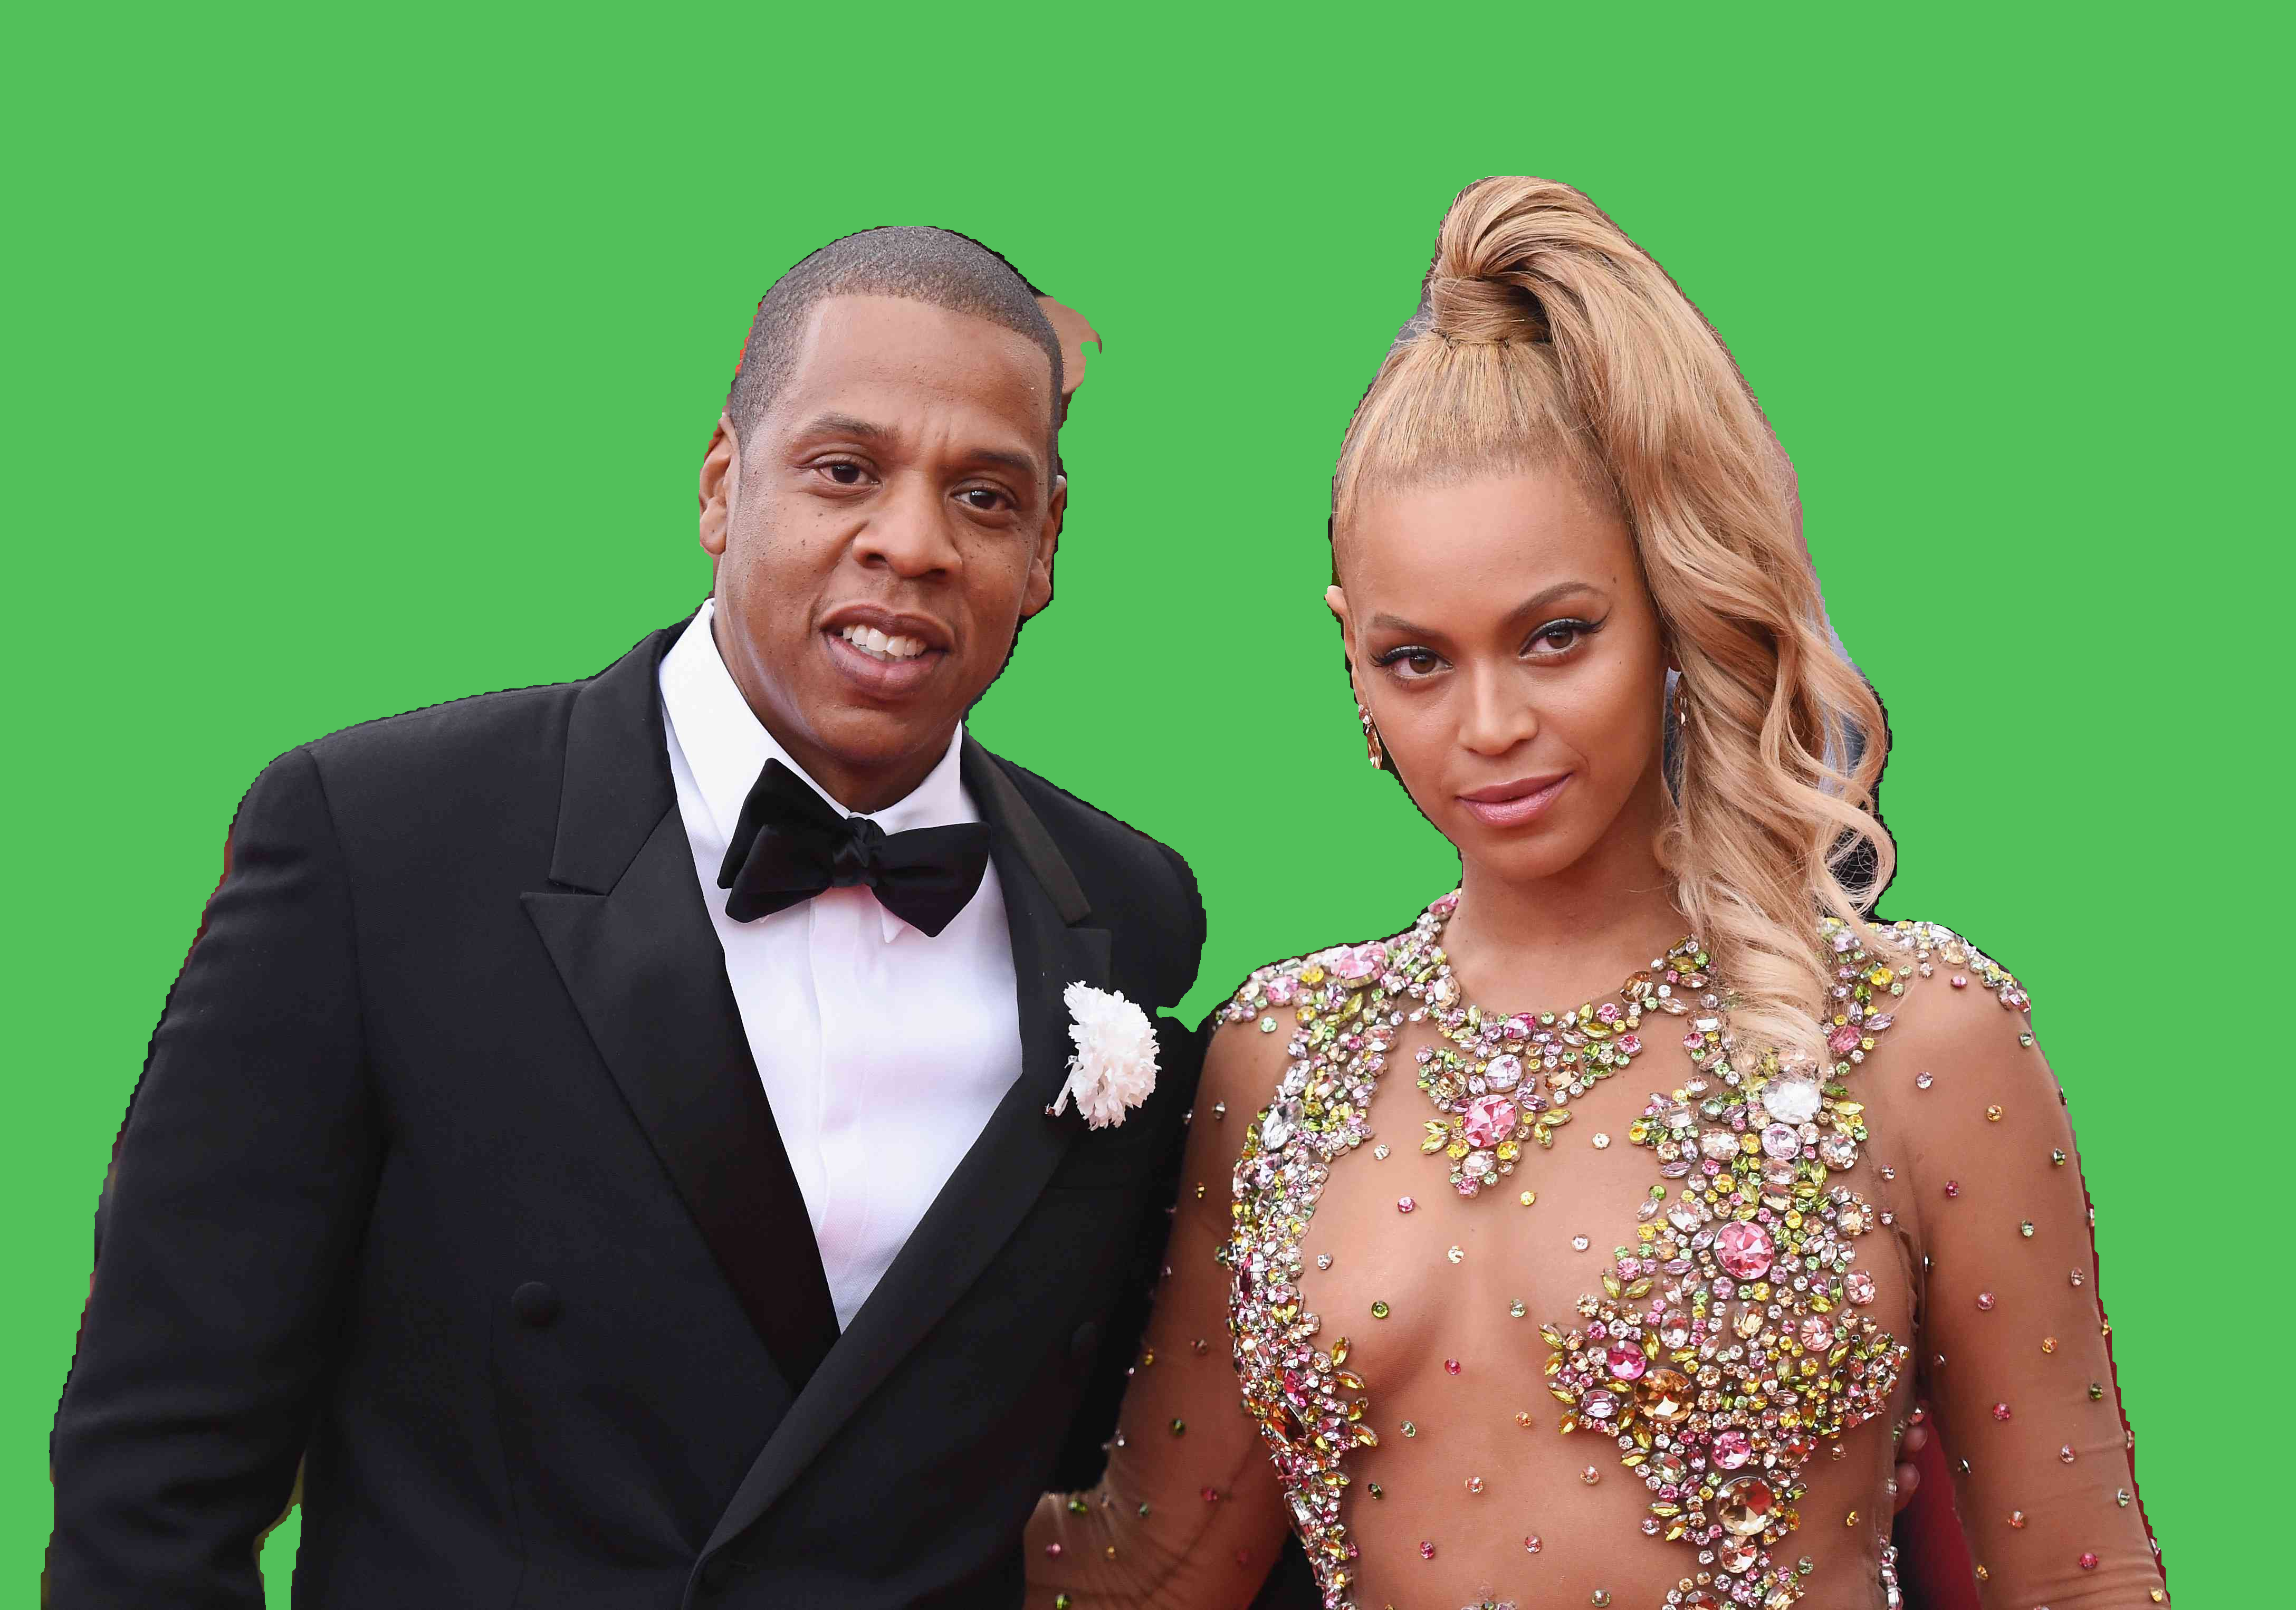

In [ ]:
cv2_imshow(img_chg_color)